# Clasificación morfológica de galaxias utilizando Redes neuronales convolucionales (CNN)

Este notebook se divide en dos secciones: 
1. **Exploración de datos**: Imágenes de galaxias obtenidas desde Sloan Digital Sky Survey (SDSS) data realease 16 (DR16) 

2. **Exploración de modelos**: Definición, entrenamiento y comparación entre distintos modelos tipo CNN

## Exploración de datos

- Visualización
- Simetrías
- Ruido
- Balance de clases

In [76]:
# Importar librerías necesarias para esta sección

import h5py
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Fontsize para gráficas
fs = 13

# Dirección del archivo HDF5 (modificar según corresponda)
path_to_file = 'galaxies_project3.h5'           

Cargar datos a `numpy.ndarray`

In [ ]:
with h5py.File(path_to_file, 'r') as f_read:
    print("Keys in the HDF5 file:", list(f_read.keys()))

    # Leer imágenes  
    dataset_data = f_read['images'][()]
    
    # Leer etiquetas
    labels = f_read['ans'][()]   

# Verificar dimensiones 
print("")
print("Images shape: ",dataset_data.shape)
print("Labels shape: ",labels.shape)

Keys in the HDF5 file: ['ans', 'images']

Images shape:  (21785, 69, 69, 3)
Labels shape:  (21785,)


In [9]:
# Nombre de cada clase en la clasificación de galaxias
string_labels = ['Disk, Face-on, No Spiral |0',
                 'Smooth, Completely round |1',
                 'Smooth, in-between round |2',
                 'Smooth, Cigar shaped |3',
                 'Disk, Edge-on, Rounded Bulge |4',
                 'Disk, Edge-on, Boxy Bulge |5',
                 'Disk, Edge-on, No Bulge |6',
                 'Disk, Face-on, Tight Spiral |7',
                 'Disk, Face-on, Medium Spiral |8',
                 'Disk, Face-on, Loose Spiral |9'] 

Visualización de algunas muestras

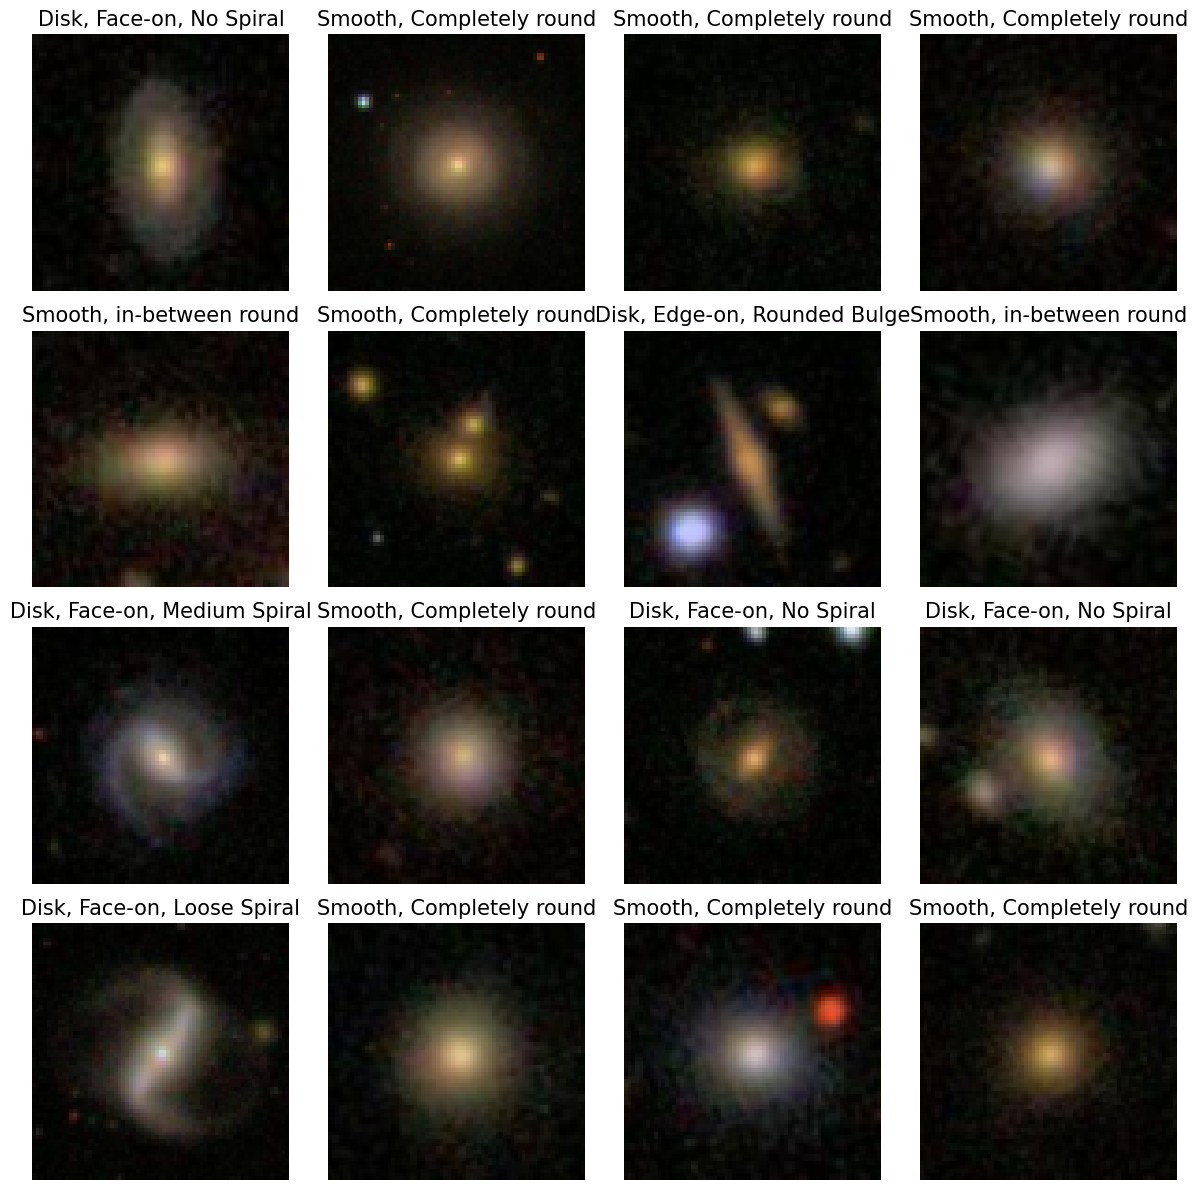

In [81]:
# Definir muestras a visualizar
num_im = 16
start_im = 15500
first_images = dataset_data[start_im:start_im+num_im]
first_labels = labels[start_im:start_im+num_im]

# Plots
plt.figure(figsize=(12,12))
for i in range(num_im):
    plt.subplot(int(np.sqrt(num_im)), int(np.sqrt(num_im)), i + 1)
    plt.imshow(first_images[i])
    plt.title(string_labels[int(first_labels[i])][:-3], fontsize=fs+2)
    plt.axis('off')
plt.tight_layout()

plt.savefig('sample120.png', dpi=400)
plt.show()

**Observaciones**:

- Se observa cómo algunas de las imágenes presentan objetos secundarios, por ejemplo la 2da y 3ra imagen de la 2da fila
- En la última de estas, clasificada como `Disk, Edge-on, Rounded Bulge |4`, el objeto secundario presenta un brillo superior a la galaxia, lo cual podría introducir un ruido considerable en el modelo de clasificación    

Cantidad de galaxias en cada clase

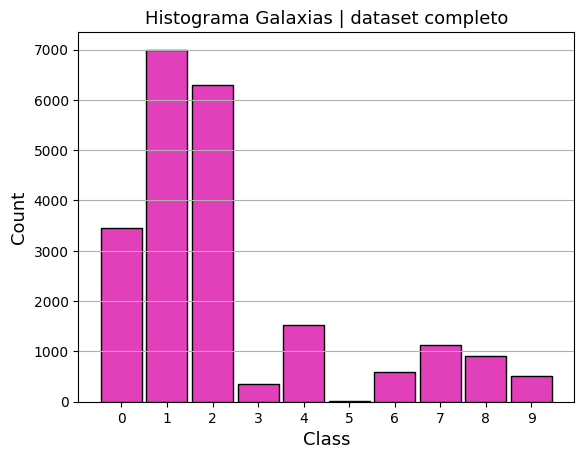

,Count
"Disk, Face-on, No Spiral |0",3461
"Smooth, Completely round |1",6997
"Smooth, in-between round |2",6292
"Smooth, Cigar shaped |3",349
"Disk, Edge-on, Rounded Bulge |4",1534
"Disk, Edge-on, Boxy Bulge |5",17
"Disk, Edge-on, No Bulge |6",589
"Disk, Face-on, Tight Spiral |7",1121
"Disk, Face-on, Medium Spiral |8",906
"Disk, Face-on, Loose Spiral |9",519


In [42]:
sns.histplot(labels, shrink=.9, discrete=True, color='#D900A4');
plt.xticks(range(10));
plt.xlabel("Class", fontsize=fs)
plt.ylabel("Count", fontsize=fs)
plt.title("Histograma Galaxias | dataset completo", fontsize=fs)
plt.grid(axis="y")
plt.show()

# Valores específicos
pd.DataFrame(np.histogram(labels, bins=10)[0], columns=['Count'], index=string_labels)

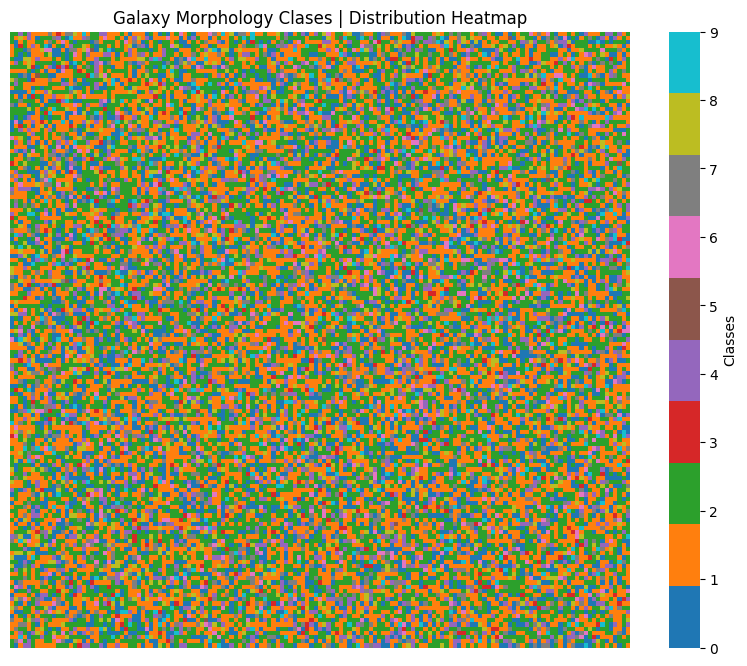

In [34]:
# Visualizar distribución de las clases en el dataset

label_matrix = np.array(labels[:int(147**2)]).reshape(147, 147)
plt.figure(figsize=(10,8))
sns.heatmap(label_matrix, cmap='tab10', cbar_kws={'label': 'Classes'})
plt.title('Galaxy Morphology Clases | Distribution Heatmap')
plt.axis('off')
plt.show()

**Observaciones**:

- Desde el histograma anterior, se aprecia como las clases `1` y `2` son las más representadas, mientras que las clases `3` y `5` las menos representadas, siendo esta última una clase extremadamente subrepresentada, con solo 17 samples en un dataset de 21785 imágenes.  
- Desde este último mapa de calor, se concluye que las clases parecen estar distribuidas de manera aleatoria dentro del dataset
 

## Exploración de modelos

1. Cargar datos 

2. Definir modelos:
    - AlexNet
    - VGG
    - ResNet

3. Entrenamiento y validación

    - Data Augmentation 
    - Whitening

4. Comparación y selección del mejor modelo

5. Testeo sobre el modelo seleccionado

### Ejemplo sin aumentación de datos

Antes de pasar a la construcción de los códigos que se utilizan para la generación de resultados, se presenta a continuación un ejemplo más sencillo del pipeline utilizado 

In [1]:
# Librerías necesarias para la siguiente sección
import numpy as np
import matplotlib.pyplot as plt
import os
import h5py
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Fijar semilla y fontsize para gráficas
SEED = 42
np.random.seed(SEED) 
torch.manual_seed(SEED);
fs = 13

# Dirección del archivo HDF5 (modificar según corresponda)
path_to_file = 'galaxies_project3.h5'    

In [3]:
# Opcionalmente, configuración de GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando dispositivo: {device}")

# Clase Dataset para cargar el archivo .h5
class GalaxyH5Dataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        if not os.path.exists(h5_path):
            raise FileNotFoundError(f"No se encuentra el archivo: {h5_path}")

        with h5py.File(h5_path, 'r') as f:
            # Cargamos los datos a memoria
            self.images = f['images'][:]
            self.labels = f['ans'][:]

        self.num_classes = len(np.unique(self.labels))
        print(f"Dataset cargado. Imágenes: {self.images.shape}, Clases: {self.num_classes}")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]      # Dimensión (69, 69, 3)
        label = self.labels[idx]

        # Normalización [0, 1] y conversión a float32
        img = img.astype(np.float32) / 255.0

        # Transposición Importante: Keras usa (Height, Width, Channels), PyTorch usa (C,H,W) 
        # Movemos el canal de la posición 2 a la 0.
        img = np.transpose(img, (2, 0, 1))

        return torch.from_numpy(img), torch.tensor(label, dtype=torch.long)

Usando dispositivo: cpu


**AlexNet**

In [7]:
# Arquitectura AlexNet
class AlexNetGalaxy(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNetGalaxy, self).__init__()

        self.features = nn.Sequential(
            # --- Bloque 1 ---
            # Keras: Conv2D(96, (11, 11), strides=(4, 4))
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(inplace=True),
            # Keras: MaxPooling2D((3, 3), strides=(2, 2))
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Keras: BatchNormalization()
            nn.BatchNorm2d(96),

            # --- Bloque 2 ---
            # Keras: Conv2D(256, (5, 5), padding='same')
            # En PyTorch, para kernel 5 mantener tamaño (padding='same'), usamos padding=2
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            # Keras: MaxPooling2D((3, 3), strides=(2, 2))
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Keras: BatchNormalization()
            nn.BatchNorm2d(256),

            # --- Bloque 3 ---
            # Keras: Conv2D(384, (3, 3), padding='same') -> padding=1 en Torch
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # --- Bloque 4 ---
            # Keras: Conv2D(384, (3, 3), padding='same')
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            # --- Bloque 5 ---
            # Keras: Conv2D(256, (3, 3), padding='same')
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # Keras: MaxPooling2D((3, 3), strides=(2, 2))
            nn.MaxPool2d(kernel_size=3, stride=2),
            # Keras: BatchNormalization()
            nn.BatchNorm2d(256),
        )

        # --- Clasificador (Dense Layers) ---
        # Salida final de features: 256 canales de 1x1 (después de las capas convolucionales y pooling)
        self.flatten_size = 256 * 1 * 1

        self.classifier = nn.Sequential(
            nn.Flatten(),

            # Keras: Dense(4096)
            nn.Linear(self.flatten_size, 4096),
            nn.ReLU(inplace=True),
            # Keras: Dropout(0.5)
            nn.Dropout(0.6),

            # Keras: Dense(4096)
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            # Keras: Dropout(0.5)
            nn.Dropout(0.6),

            # Keras: Dense(num_classes)
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=100):
    # Listas para guardar el historial
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        # --- Entrenamiento ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train

        # Guardar métricas de entrenamiento
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)

        # --- Validación ---
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_acc = 100 * val_correct / val_total

        # Guardar métricas de validación
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)

        print(f"Época [{epoch+1}/{epochs}] "
              f"Train Loss: {epoch_train_loss:.4f} | Val Loss: {epoch_val_loss:.4f} | "
              f"Train Acc: {epoch_train_acc:.2f}% | Val Acc: {epoch_val_acc:.2f}%")

    return history

**ResNet**

In [4]:
# Arquitectura ResNet
import torch.nn.functional as F

# -------------------------
# Bloque Residual Básico
# -------------------------
class BasicBlock(nn.Module):
    expansion = 1  # ResNet básico

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = downsample
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        identity = x

        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

# --------------------------------------
#     ResNet para Galaxy Classification
# --------------------------------------
class ResNetGalaxy(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNetGalaxy, self).__init__()

        self.in_channels = 64

        # Entrada: 3 canales, tamaño 69x69
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ---- Etapas de ResNet ----
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # El tamaño depende de 69×69, calculamos:
        # 69 → 35 → 18 → 9 → 5 → 3 (aprox)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Clasificador final
        self.fc = nn.Linear(512, num_classes)

    # Crea una capa ResNet (varios bloques)
    def _make_layer(self, out_channels, blocks, stride):
        downsample = None

        # Cuando cambia # de canales o stride, ajustamos el "skip"
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, kernel_size=1,
                          stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = []
        layers.append(BasicBlock(self.in_channels, out_channels, stride, downsample))

        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)

        x = self.layer1(x)  # 64
        x = self.layer2(x)  # 128
        x = self.layer3(x)  # 256
        x = self.layer4(x)  # 512

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

***Entrenamiento AlexNet***

In [5]:
def data_and_training(MODEL, BATCH_SIZE=256, EPOCHS=100):

    # Crear Dataset y dividirlo
    dataset = GalaxyH5Dataset(path_to_file)

    # Porcentajes para dividir el dataset
    train_percent = 0.70
    val_percent = 0.15

    # Calcular longitudes absolutas
    total_len = len(dataset)
    train_len = int(total_len * train_percent)
    val_len = int(total_len * val_percent)
    test_len = total_len - train_len - val_len

    # Dividir el dataset
    train_set, val_set, test_set = random_split(dataset, [train_len, val_len, test_len])

    # Crear DataLoaders
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
    #test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)          # aún no es necesario

    # Instanciar Modelo, Criterio y Optimizador
    if MODEL == "AlexNet":
        model = AlexNetGalaxy(num_classes=10).to(device)
    elif MODEL == "ResNet":
        model = ResNetGalaxy(num_classes=10).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0008)

    # Llamada para entrenar
    history = train_model(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        epochs=EPOCHS
    )

    return history, model, val_loader

In [8]:
history, model, val_loader = data_and_training(MODEL="ResNet", BATCH_SIZE=4000, EPOCHS=8)

Dataset cargado. Imágenes: (21785, 69, 69, 3), Clases: 10
Época [1/8] Train Loss: 2.0496 | Val Loss: 2.0382 | Train Acc: 24.88% | Val Acc: 16.07%
Época [2/8] Train Loss: 1.2898 | Val Loss: 1.9156 | Train Acc: 47.86% | Val Acc: 31.77%
Época [3/8] Train Loss: 1.1085 | Val Loss: 2.2678 | Train Acc: 56.28% | Val Acc: 31.77%
Época [4/8] Train Loss: 0.9641 | Val Loss: 2.2316 | Train Acc: 63.37% | Val Acc: 31.74%
Época [5/8] Train Loss: 1.0030 | Val Loss: 2.8648 | Train Acc: 62.52% | Val Acc: 31.77%
Época [6/8] Train Loss: 0.8337 | Val Loss: 2.2597 | Train Acc: 69.00% | Val Acc: 37.25%
Época [7/8] Train Loss: 0.7606 | Val Loss: 3.1715 | Train Acc: 71.83% | Val Acc: 33.76%
Época [8/8] Train Loss: 0.7556 | Val Loss: 3.6688 | Train Acc: 72.27% | Val Acc: 42.36%


**Obs**: para una cantidad de épocas razonable, se recomienda correr en GPU

**Resultados**

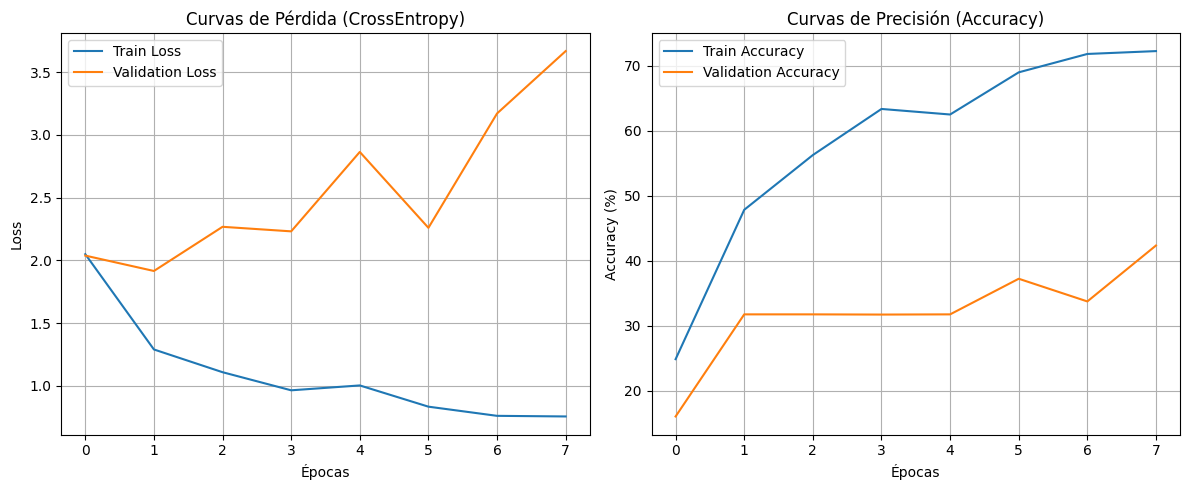

In [9]:
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    # Gráfica de Pérdida (Loss)
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Curvas de Pérdida (CrossEntropy)')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Gráfica de Precisión (Accuracy)
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Train Accuracy')
    plt.plot(history['val_acc'], label='Validation Accuracy')
    plt.title('Curvas de Precisión (Accuracy)')
    plt.xlabel('Épocas')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    #plt.savefig('training_curves.png')
    plt.show()

plot_training_history(history)

Naturalmente, estas gráficas solo deben considerarse como muestras del proceso de entrenamiento y no en conexión con los resultados finales de este proyecto.

Predicciones sobre el grupo de validación

In [10]:
import numpy as np

# 1. Set the model to evaluation mode
model.eval()

# 2. Initialize empty lists to store true and predicted labels
y_true = []
y_pred = []

# 3. Disable gradient calculations for inference
with torch.no_grad():
    # 4. Iterate through the val_loader
    for images, labels in val_loader:
        # a. Move the images and labels to the computation device
        images, labels = images.to(device), labels.to(device)

        # b. Get the model's outputs
        outputs = model(images)

        # c. Determine the predicted class
        _, predicted = torch.max(outputs.data, 1)

        # d. Append true and predicted labels to their respective lists
        y_true.append(labels.cpu().numpy())
        y_pred.append(predicted.cpu().numpy())

# 5. Concatenate all elements into single NumPy arrays
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

print("True labels collected:", y_true.shape)
print("Predicted labels collected:", y_pred.shape)

True labels collected: (3267,)
Predicted labels collected: (3267,)


**Matriz de confusión**

Dataset cargado. Imágenes: (21785, 69, 69, 3), Clases: 10


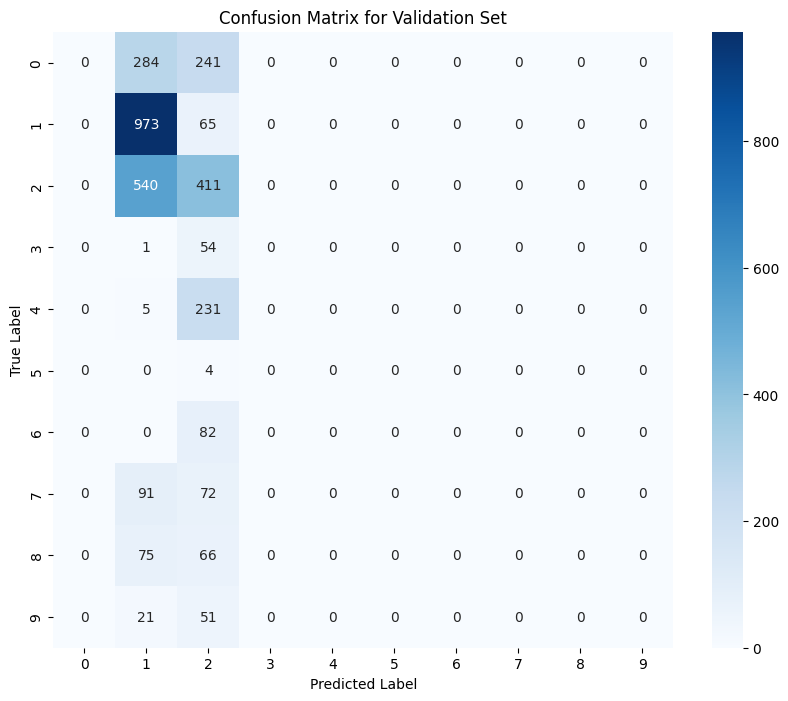

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
dataset = dataset = GalaxyH5Dataset(path_to_file) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=range(dataset.num_classes), yticklabels=range(dataset.num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Validation Set')

#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

Curvas ROC

In [13]:
import torch.nn.functional as F

# 1. Set the model to evaluation mode
model.eval()

# 2. Initialize empty list to store predicted probabilities
y_probabilities = []

# Initialize an empty list to store true labels for ROC curve calculation (if needed later)
y_true_roc = []

# 3. Disable gradient calculations for inference
with torch.no_grad():
    # 4. Iterate through the val_loader
    for images, labels in val_loader:
        # a. Move the images and labels to the computation device
        images = images.to(device)

        # b. Get the model's outputs (logits)
        outputs = model(images)

        # c. Apply a softmax function to these logits to convert them into probabilities
        probabilities = F.softmax(outputs, dim=1)

        # d. Move these probabilities to the CPU and convert them to a NumPy array
        y_probabilities.append(probabilities.cpu().numpy())
        y_true_roc.append(labels.cpu().numpy())

# 5. Concatenate all collected probabilities into a single NumPy array
y_pred_probabilities = np.concatenate(y_probabilities, axis=0)
y_true_roc = np.concatenate(y_true_roc, axis=0)

print("Shape of predicted probabilities:", y_pred_probabilities.shape)
print("Shape of true labels for ROC:", y_true_roc.shape)

Shape of predicted probabilities: (3267, 10)
Shape of true labels for ROC: (3267,)


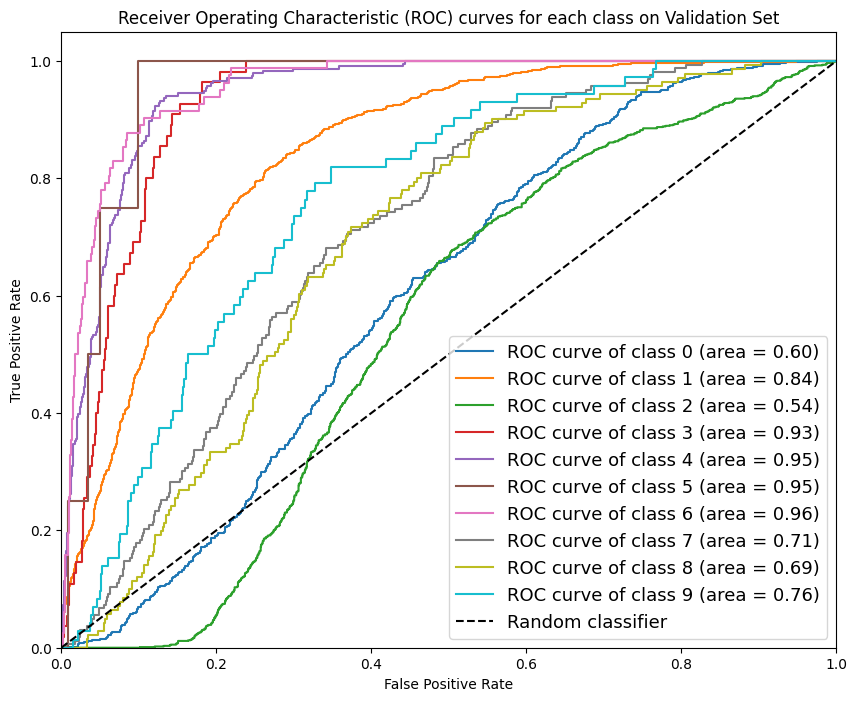

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(dataset.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_roc == i, y_pred_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(dataset.num_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {i} (area = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) curves for each class on Validation Set')
plt.legend(loc="lower right", fontsize=fs)

#plt.savefig('roc_curves.png', dpi=300)
plt.show()


**Métricas**

In [16]:
# Métricas
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

def calculate_multiclass_metrics(cm):
    """
    Calculates Macro-Averaged Precision, Recall, F1-Score, and overall Accuracy
    from true labels and predicted labels for a multiclass classification problem.

    Args:
        y_true (array): Ground truth (correct) target values.
        y_pred (array): Estimated targets as returned by a classifier.
        labels (list, optional): List of labels to index the matrix. If None,
                                  labels are inferred from the data.

    Returns:
        dict: A dictionary containing 'accuracy', 'macro_precision',
              'macro_recall', and 'macro_f1'.
    """
    # 1. Generate the Confusion Matrix (C)
    #C = confusion_matrix(y_true, y_pred, labels=labels)
    C = cm
    num_classes = C.shape[0]

    # Calculate Overall Accuracy (sum of diagonal / sum of all elements)
    overall_accuracy = np.trace(C) / np.sum(C)

    # Initialize lists to store metrics for each class
    precision_list = []
    recall_list = []
    f1_list = []

    # 2. Iterate over each class (One-vs-Rest approach)
    for i in range(num_classes):
        # The confusion matrix uses: Rows = True Class, Columns = Predicted Class

        # True Positives (TP): Correctly predicted class i
        TP = C[i, i]

        # False Negatives (FN): True class i, but predicted as something else (Row sum excluding diagonal)
        FN = np.sum(C[i, :]) - TP

        # False Positives (FP): True class is NOT i, but predicted as i (Column sum excluding diagonal)
        FP = np.sum(C[:, i]) - TP

        # Handle the case where the class might not have any true instances (TP + FN = 0)
        # or no predicted instances (TP + FP = 0) to prevent ZeroDivisionError.
        if (TP + FP) > 0:
            precision = TP / (TP + FP)
        else:
            precision = 0.0

        if (TP + FN) > 0:
            recall = TP / (TP + FN)
        else:
            recall = 0.0

        # F1-Score calculation
        if (precision + recall) > 0:
            f1_score = 2 * (precision * recall) / (precision + recall)
        else:
            f1_score = 0.0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1_score)

    # 3. Calculate Macro Averages (unweighted mean of per-class metrics)
    macro_precision = np.mean(precision_list)
    macro_recall = np.mean(recall_list)
    macro_f1 = np.mean(f1_list)

    return {
        "accuracy": overall_accuracy,
        "macro_precision": macro_precision,
        "macro_recall": macro_recall,
        "macro_f1": macro_f1,
        "per_class_precision": precision_list,
        "per_class_recall": recall_list,
        "per_class_f1": f1_list,
    }

# Matriz de confusión
print(cm)
print("-" * 30)

# Caclular métricas
custom_metrics = calculate_multiclass_metrics(cm)

print("--- Macro Averages ---")
print(f"Overall Accuracy:   {custom_metrics['accuracy']:.4f}")
print(f"Macro Precision:    {custom_metrics['macro_precision']:.4f}")
print(f"Macro Recall:       {custom_metrics['macro_recall']:.4f}")
print(f"Macro F1-Score:     {custom_metrics['macro_f1']:.4f}")
print("\nPer-Class Metrics:")

class_labels = list(range(9))
for i, label in enumerate(class_labels):
    print(f"  Class {label} | P: {custom_metrics['per_class_precision'][i]:.4f} | R: {custom_metrics['per_class_recall'][i]:.4f} | F1: {custom_metrics['per_class_f1'][i]:.4f}")
print("-" * 30)


# Verificación con classification_report de scikit-learn
#print("\n--- scikit-learn Classification Report (Verification) ---")
# The report provides:
# - Precision, Recall, F1 for each class.
# - Micro, Macro, and Weighted Averages.
#print(classification_report(y_true, y_pred, target_names=class_labels, zero_division=0))

# Note on Micro vs. Accuracy:
# Micro-Average is mathematically equivalent to overall Accuracy.
micro_f1 = accuracy_score(y_true, y_pred)
print(f"Micro F1-Score / Overall Accuracy (Verification): {micro_f1:.4f}")

[[  0 284 241   0   0   0   0   0   0   0]
 [  0 973  65   0   0   0   0   0   0   0]
 [  0 540 411   0   0   0   0   0   0   0]
 [  0   1  54   0   0   0   0   0   0   0]
 [  0   5 231   0   0   0   0   0   0   0]
 [  0   0   4   0   0   0   0   0   0   0]
 [  0   0  82   0   0   0   0   0   0   0]
 [  0  91  72   0   0   0   0   0   0   0]
 [  0  75  66   0   0   0   0   0   0   0]
 [  0  21  51   0   0   0   0   0   0   0]]
------------------------------
--- Macro Averages ---
Overall Accuracy:   0.4236
Macro Precision:    0.0811
Macro Recall:       0.1370
Macro F1-Score:     0.1012

Per-Class Metrics:
  Class 0 | P: 0.0000 | R: 0.0000 | F1: 0.0000
  Class 1 | P: 0.4889 | R: 0.9374 | F1: 0.6427
  Class 2 | P: 0.3218 | R: 0.4322 | F1: 0.3689
  Class 3 | P: 0.0000 | R: 0.0000 | F1: 0.0000
  Class 4 | P: 0.0000 | R: 0.0000 | F1: 0.0000
  Class 5 | P: 0.0000 | R: 0.0000 | F1: 0.0000
  Class 6 | P: 0.0000 | R: 0.0000 | F1: 0.0000
  Class 7 | P: 0.0000 | R: 0.0000 | F1: 0.0000
  Class 8 |

**Guardar Resultados**

In [19]:
def save_metrics_to_file(metrics_data, filepath="multiclass_summary.txt"):
    """
    Writes the calculated multiclass metrics to a text file in Markdown format.
    """
    output = []

    output.append("Multiclass Classification Metric Summary")
    output.append("\nDataset: Sample Data")
    output.append(f"Classes: {list(range(9))}")
    output.append(f"Total Samples: {len(y_true)}")
    output.append("\n\n--- Aggregated (Macro) Metrics ---")

    output.append(f"\nOverall Accuracy: {metrics_data['accuracy']:.4f}")
    output.append("(Micro-Average F1 is equal to Overall Accuracy)")

    output.append(f"\nMacro Precision: {metrics_data['macro_precision']:.4f}")
    output.append(f"Macro Recall: {metrics_data['macro_recall']:.4f}")
    output.append(f"Macro F1-Score: {metrics_data['macro_f1']:.4f}")

    output.append("\n\n--- Per-Class Metrics (One-vs-Rest) ---")
    output.append("\n| Class | Precision (P) | Recall (R) | F1-Score |")
    output.append("| ----- | ----- | ----- | ----- |")

    for i, label in enumerate(list(range(9))):
        line = f"| {label} | {metrics_data['per_class_precision'][i]:.4f} | {metrics_data['per_class_recall'][i]:.4f} | {metrics_data['per_class_f1'][i]:.4f} |"
        output.append(line)

    with open(filepath, "w") as f:
        f.write('\n'.join(output))

# Save metrics
output_filename = "multiclass_summary.txt"
save_metrics_to_file(custom_metrics, filepath=output_filename)

### Pipeline completo

---
Hasta ahora se trabajó con celdas independientes para ilustrar cada paso del pipeline.

A continuación se presenta una menera más conveniente y directa de realizar todo este proceso:

- Definir el código completo de cada modelo en un archivo `.py`
- Correr este código desde una terminal, donde los argumentos que requiere el código son la cantidad de épocas y el batch_size para el entrenamiento   

De esta forma el traslado por ejemplo a **Google Colab** resulta directo: Subir el código y datos correspondientes, y correr la siguiente linea: 

```bash
!python3 /content/Galaxy_class_CNN.py [epochs] [batch_size]
```

**Obs**: Dado que el archivo original de datos pesa alrededor de 210MB, se recomienda leerlos desde Google Drive, para lo cual se deben correr estas lineas de manera previa:

```Python
from google.colab import drive
drive.mount('/content/drive')
```

Asegurando que los paths sean los correctos, se muestran ejemplos de uso de los códigos construidos.

Automáticamente se guardarán:

1. Graficas de pérdida y accuracy para entrenamiento y validación
2. Matriz de confusión sobre el grupo de validación
3. Métricas derivadas desde la matriz de confusión
4. Curvas ROC

In [ ]:
# Ejemplo: ResNet con Data Augmentation, 100 épocas, batch size 256

!python3 ResNet_wDataAug.py 100 256

In [ ]:
!python3 /content/ResNet_NoDataAug.py 80 256

In [ ]:
!python3 /content/Galaxy_Inception.py 80 128

Códigos disponibles:

1. `ResNet_NoDataAug.py`: Arquitectura ResNet, sin DataAugmentation, sin balance de clases

2. `ResNet_wDataAug.py`: Arquitectura ResNet, DataAugmentaion (rotations + flips), sin balance de clases

3. `Galaxy_Inception.py`: Arquitectura Inception, DataAugmentation (rotations + flips), balance de clases 

4. `AlexNetWhitening.py`: Arquitectura AlexNet, DataAugmentation (rotations + flips), Whitening, sin balance de clases

5. `AlexNet_NoDataAug.py`: Arquitectura AlexNet, sin DataAugmentation, sin balance de clases


**Obs**: El tiempo que demore cada uno de estos códigos depende de la cantidad de épocas y batch_size que se utilice, pero principalmente del uso (o no) de GPU.